# Generate AUC and AUPR Graphs

In [1]:
import os

import numpy as np

import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Data, Dataset
from tqdm import tqdm
from datasets.datasetMouseBrain import MouseBrainDataset
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from statistics import mean
%matplotlib inline

Torch version: 1.8.0+cu111
Cuda available: True
Torch geometric version: 2.0.3


In [2]:
from scipy.special import softmax

def testForAUC(loader, size):
    model.eval()
    toReturn = np.zeros((len(loader), size))
    ind = 0
    actual = np.zeros((len(loader), size))
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.x = torch.reshape(data.x, (data.x.shape[0], 1))
        data.x = data.x.type(torch.FloatTensor)
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        toReturn[ind] = softmax(out.cpu().detach().numpy())
        actual[ind][data.y] = 1
        ind+=1
    return toReturn, actual

## Mouse Brain

In [3]:
dataset = MouseBrainDataset("/gpfs/data/rsingh47/hzaki1/data")

100%|██████████| 243075/243075 [00:09<00:00, 26398.81it/s]


In [4]:
shuffle_index = np.loadtxt('shuffle_indices/shuffleIndex_MouseBrain.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_dataset = [dataset[i] for i in shuffle_index[0:train_size]]
val_dataset = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_dataset =  [dataset[i] for i in shuffle_index[val_size:]]

In [5]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=7).to(device)
model.load_state_dict(torch.load('model_weightsDec4LogwShuffleIndex_250Epochs_2Dropout.pth'))

<All keys matched successfully>

In [6]:
test_loader_auc = DataLoader(test_dataset, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc, 7)

/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0.9815826657650222


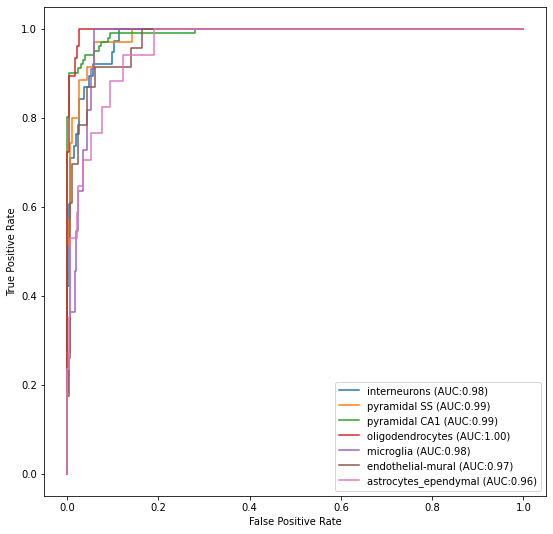

In [7]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)
average = []

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    average.append(auc(fpr, tpr))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print(mean(average))

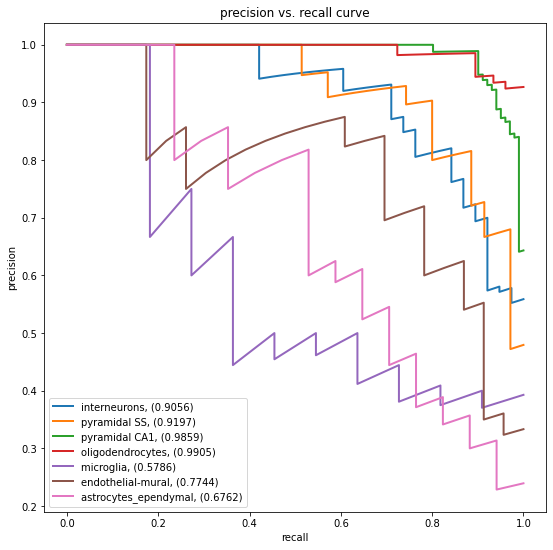

0.8329857142857143


In [8]:
# precision recall curve
precision = dict()
recall = dict()
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
average = []

for (idx, c_label) in enumerate(all_labels):
    precision[idx], recall[idx], _ = precision_recall_curve(test_labels[:, idx],
                                                        predics[:, idx])
    auc(recall[idx], precision[idx])
    plt.plot(recall[idx], precision[idx], lw=2, label=f'{c_label}, ({round(auc(recall[idx], precision[idx]),4)})')
    average.append(round(auc(recall[idx], precision[idx]),4))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
print(mean(average))

## Baron Human

In [9]:
from datasetbaronhuman import BaronHumanDataset
dataset = BaronHumanDataset("/gpfs/data/rsingh47/hzaki1/data-baron-human")

Torch version: 1.10.0+cu102
Cuda available: True
Torch geometric version: 2.0.2


100%|██████████| 181366/181366 [00:12<00:00, 14210.90it/s]


In [10]:
shuffle_index = np.loadtxt('shuffle_index_BaronHuman.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_dataset = [dataset[i] for i in shuffle_index[0:train_size]]
val_dataset = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_dataset =  [dataset[i] for i in shuffle_index[val_size:]]

In [11]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=14).to(device)
model.load_state_dict(torch.load('model_weightsSept20BaronHuman.pth'))

<All keys matched successfully>

In [12]:
test_loader_auc = DataLoader(test_dataset, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc, 14)

/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan


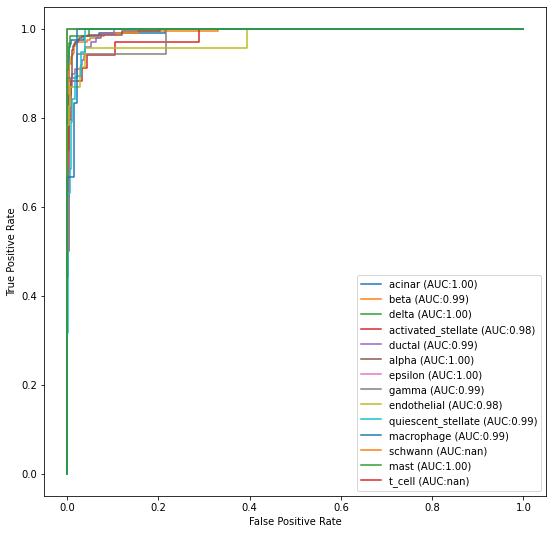

In [13]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)
average = []

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    average.append(auc(fpr, tpr))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print(mean(average))

/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


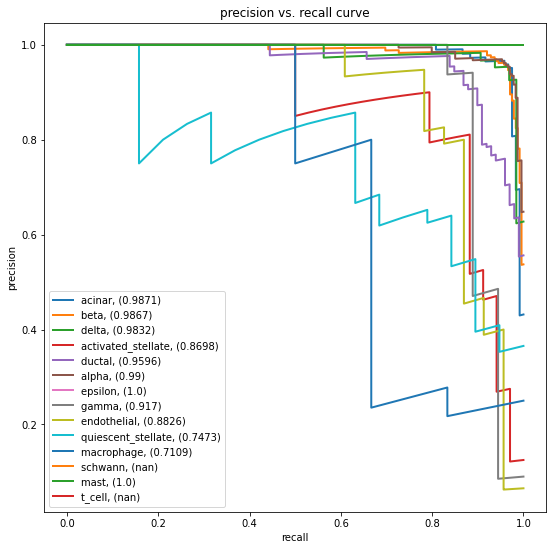

nan


In [14]:
# precision recall curve
precision = dict()
recall = dict()
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
average = []

for (idx, c_label) in enumerate(all_labels):
    precision[idx], recall[idx], _ = precision_recall_curve(test_labels[:, idx],
                                                        predics[:, idx])
    auc(recall[idx], precision[idx])
    plt.plot(recall[idx], precision[idx], lw=2, label=f'{c_label}, ({round(auc(recall[idx], precision[idx]),4)})')
    average.append(round(auc(recall[idx], precision[idx]),4))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
print(mean(average))

## Baron Mouse

In [4]:
from datasets.datasetbaronmouse import BaronMouseDataset
dataset = BaronMouseDataset("/gpfs/data/rsingh47/hzaki1/data-baron-mouse")

Torch version: 1.8.0+cu111
Cuda available: True
Torch geometric version: 2.0.3


100%|██████████| 139607/139607 [00:06<00:00, 19980.47it/s]


In [6]:
shuffle_index = np.loadtxt('shuffle_indices/shuffle_index_BaronMouse.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_dataset = [dataset[i] for i in shuffle_index[0:train_size]]
val_dataset = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_dataset =  [dataset[i] for i in shuffle_index[val_size:]]

In [7]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=13).to(device)
model.load_state_dict(torch.load('model_weights/model_weightsBaronMouse.pth'))

<All keys matched successfully>

In [8]:
test_loader_auc = DataLoader(test_dataset, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc, 13)

/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


nan


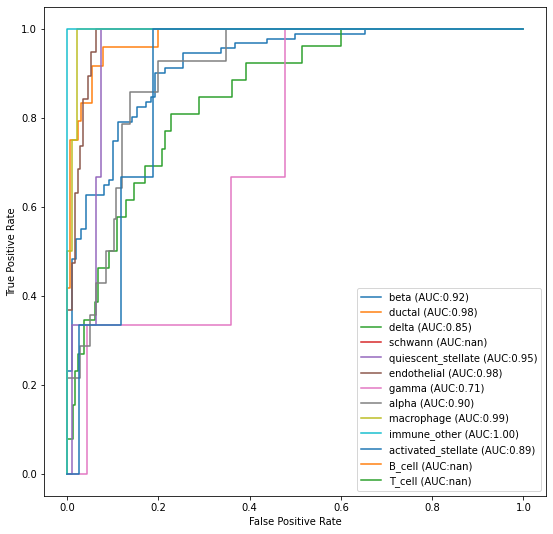

In [9]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)
average = []


for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    average.append(auc(fpr, tpr))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print(mean(average))

/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/gpfs/home/hzaki1/celltypefromgrn/env-gpu/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


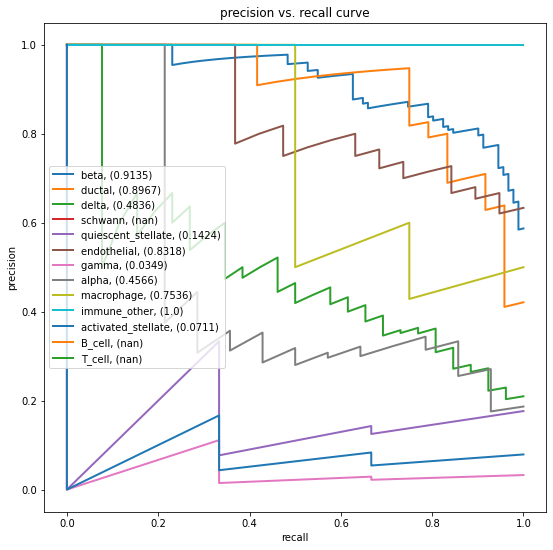

nan


In [10]:
# precision recall curve
precision = dict()
recall = dict()
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
average = []

for (idx, c_label) in enumerate(all_labels):
    precision[idx], recall[idx], _ = precision_recall_curve(test_labels[:, idx],
                                                        predics[:, idx])
    auc(recall[idx], precision[idx])
    plt.plot(recall[idx], precision[idx], lw=2, label=f'{c_label}, ({round(auc(recall[idx], precision[idx]),4)})')
    average.append(round(auc(recall[idx], precision[idx]),4))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
print(mean(average))

## Muraro

In [21]:
from datasetmuraro import MuraroDataset
dataset = MuraroDataset("/gpfs/data/rsingh47/hzaki1/data-muraro")

Torch version: 1.10.0+cu102
Cuda available: True
Torch geometric version: 2.0.2


100%|██████████| 368087/368087 [00:25<00:00, 14161.94it/s]


In [22]:
shuffle_index = np.loadtxt('/gpfs/data/rsingh47/hzaki1/data-muraro/resources/shuffle_index_Muraro.txt')
shuffle_index = shuffle_index.astype(np.int32)
train_size, val_size = int(len(shuffle_index)* 0.8), int(len(shuffle_index)* 0.9)
train_dataset = [dataset[i] for i in shuffle_index[0:train_size]]
val_dataset = [dataset[i] for i in shuffle_index[train_size: val_size]]
test_dataset =  [dataset[i] for i in shuffle_index[val_size:]]

In [23]:
from gcnmodel import GCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(hidden_channels=128, data=dataset, output_size=9).to(device)
model.load_state_dict(torch.load('model_weightsNov26_muraro_fixedOutputSize.pth'))

<All keys matched successfully>

In [24]:
test_loader_auc = DataLoader(test_dataset, batch_size=1, shuffle=False)
predics, test_labels = testForAUC(test_loader_auc, 9)

/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


nan


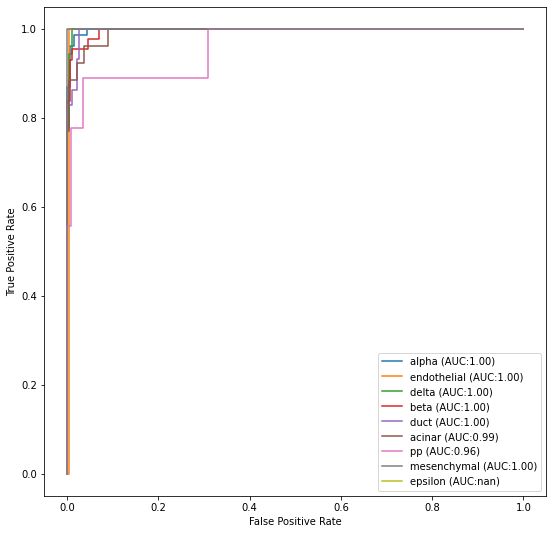

In [25]:
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

all_labels = list(dataset.cellToIndex.keys())
test_labels = np.array(test_labels)
average = []

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_labels[:,idx].astype(int), predics[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    average.append(auc(fpr, tpr))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
print(mean(average))

/gpfs/home/hzaki1/celltypefromgrn/env/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


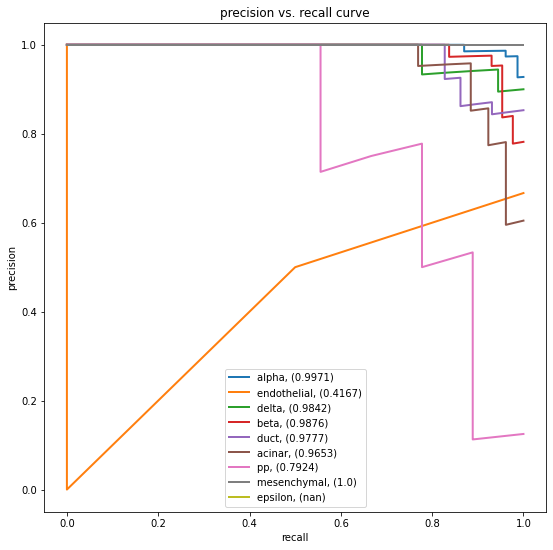

nan


In [26]:
# precision recall curve
precision = dict()
recall = dict()
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
average = []

for (idx, c_label) in enumerate(all_labels):
    precision[idx], recall[idx], _ = precision_recall_curve(test_labels[:, idx],
                                                        predics[:, idx])
    auc(recall[idx], precision[idx])
    plt.plot(recall[idx], precision[idx], lw=2, label=f'{c_label}, ({round(auc(recall[idx], precision[idx]),4)})')
    average.append(round(auc(recall[idx], precision[idx]),4))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()
print(mean(average))

## atac seq

In [ ]:
datasetChromatin = AtacSeqChromatinDataset("/gpfs/data/rsingh47/hzaki1/atacseqdataChromatin")
datasetReg = AtacSeqDataset("/gpfs/data/rsingh47/hzaki1/atacseqdata")